## 1: Utilizando a base de dados [Higher Education Students Performance Evaluation](https://www.kaggle.com/datasets/csafrit2/higher-education-students-performance-evaluation), elabore uma solução para identificar a saída GRADE do estudante.

### a) Faça o pré-processamento dos dados (limpeza, engenharia de variáveis, etc). Utilize pelo menos uma forma de redimensionamento de atributos (selecionando ou agregando) e utilize ambas as amostras para avaliar os resultados.

In [ ]:
from pandas import read_csv

df = read_csv("databases/student_prediction.csv")

classes = ["Fail", "DD", "DC", "CC", "CB", "BB", "BA", "AA"]

Retiramos colunas que não agregam à analise:

In [ ]:
# Removendo colunas de identificação
df = df.drop(columns=["STUDENTID", "COURSE ID"])

Como todos os dados categóricos já foram convertidos em números, não precisamos fazer essa etapa:

In [ ]:
df.dtypes

Tratamos possíveis dados defeituosos:

In [ ]:
# Removendo dados duplicados
df = df.drop_duplicates()
# Removendo dados nulos
df = df.dropna()

Usamos correlação para identificar variáveis independentes que podem ser removidas:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils.cmap import lukewarm_cmap

plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(), cmap=lukewarm_cmap)
plt.show()

Considerando um nível alto de correlação como >= 0.6, podemos remover o atributo "EXP_GPA" (que nada mais é do que uma previsão do CUML_GPA) em favor de "CUML_GPA".

In [ ]:
df_best = df.drop(columns=["EXP_GPA"])

Poderíamos reduzir ainda mais as variáveis juntando as 4 de pai e mãe (escolaridade e trabalho) em uma única de parentes, assim como as 2 sobre leitura de livros. Porém, na minha opinião, isso poderia acarretar numa possível perda de *insight*.

### b) Faça uma análise exploratória dos dados de saída, utilizando box plot, e aplique undersampling ou oversampling para balancear os dados caso preciso.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x="GRADE", data=df)
plt.show()

Podemos notar uma diferença no tamanho das caudas, sem presença de outliers, e que a mediana não está no centro do gráfico. Isso nos mostra um forte desbalanceamento para os valores menores, portanto aplicaremos oversampling através da técnica "Synthetic Minority Over-sampling Technique" implementada pela biblioteca Imbalanced-learn:

In [ ]:
from imblearn.over_sampling import SMOTE

df = [df.iloc[:, :-1], df.iloc[:, -1]]
df_best = [df_best.iloc[:, :-1], df_best.iloc[:, -1]]

smote = SMOTE(random_state=2456)
df = smote.fit_resample(df[0], df[1])
df_best = smote.fit_resample(df_best[0], df_best[1])

Com isto, a mediana encontra-se devidamente no centro dos valores e as distâncias entre os percentils e as caudas estãos iguais, portanto as amostras foram balançeadas.

In [ ]:
sns.boxplot(data=df_best[1], orient="horizontal")
plt.show()

### c) Utilize a biblioteca AutoML para fazer a previsão, com validação cruzada estratificada 10-fold e "random_state" fixo. Identifique o algoritmo que teve o melhor resultado e teste 3 variações de um dos seus hiperparâmetros. Avalie os resultados com matrizes de confusão e 2 métricas de sua preferência.

In [40]:
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import accuracy, average_precision, f1, precision, recall, roc_auc
from IPython.display import display
from pandas import DataFrame
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from warnings import simplefilter

simplefilter("ignore")

x_train, x_test, y_train, y_test = train_test_split(df[0], df[1], test_size=0.33, random_state=42, stratify=df[1])

automl = AutoSklearnClassifier(
    time_left_for_this_task=60 * 5,
    per_run_time_limit=60,
    # metric=f1_macro
    # include={"classifier": ["mlp"]},
    # initial_configurations_via_metalearning=0,
    resampling_strategy="cv",
    resampling_strategy_arguments={"folds": 10}
)

automl.fit(x_train, y_train, dataset_name="Higher Education Students Performance Evaluation")
automl.refit(x_train, y_train)

AutoSklearnClassifier(per_run_time_limit=60, resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 10},
                      time_left_for_this_task=300)

In [41]:
results = automl.predict(x_test)

print("Acurácia: ", accuracy_score(y_test, results))
print("F1 Score: ", f1_score(y_test, results, average="macro"))
print(automl.leaderboard())

Acurácia:  0.7741935483870968
F1 Score:  0.7725454798824364
          rank  ensemble_weight                type      cost   duration
model_id                                                                
13           1             0.12  passive_aggressive  0.379679  15.105822
2            2             0.20       random_forest  0.417112  16.499907
5            3             0.12          libsvm_svc  0.422460   5.105473
7            4             0.20          libsvm_svc  0.427807   6.230934
15           5             0.04                 lda  0.443850   7.699226
12           6             0.16       random_forest  0.465241  47.775623
11           7             0.04                 mlp  0.534759   8.348006
10           8             0.04       random_forest  0.577540  15.924776
4            9             0.08       random_forest  0.695187  14.172450


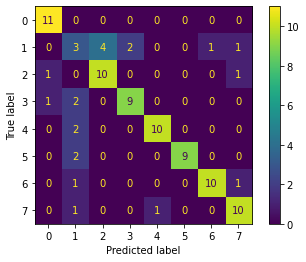

In [42]:
cm = confusion_matrix(y_test, results)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [43]:
# print(automl.sprint_statistics())
display(DataFrame(automl.cv_results_).sort_values(by=["rank_test_scores"]))
bestParams = automl.cv_results_["params"][0]

,mean_test_score,mean_fit_time,params,rank_test_scores,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,...,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_min,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
11,0.620321,15.105822,"{'balancing:strategy': 'none', 'classifier:__c...",1,Success,0.0,none,passive_aggressive,feature_type,polynomial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.582888,16.499907,"{'balancing:strategy': 'none', 'classifier:__c...",2,Success,0.0,none,random_forest,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.577540,5.105473,"{'balancing:strategy': 'none', 'classifier:__c...",3,Success,0.0,none,libsvm_svc,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.572193,6.230934,"{'balancing:strategy': 'weighting', 'classifie...",4,Success,0.0,weighting,libsvm_svc,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,0.556150,7.699226,"{'balancing:strategy': 'weighting', 'classifie...",5,Success,0.0,weighting,lda,feature_type,polynomial,...,0.777883,0.185241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.545455,13.338732,"{'balancing:strategy': 'weighting', 'classifie...",6,Success,0.0,weighting,mlp,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.534759,47.775623,"{'balancing:strategy': 'none', 'classifier:__c...",7,Success,0.0,none,random_forest,feature_type,polynomial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.465241,8.348006,"{'balancing:strategy': 'none', 'classifier:__c...",8,Success,0.0,none,mlp,feature_type,liblinear_svc_preprocessor,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.422460,15.924776,"{'balancing:strategy': 'none', 'classifier:__c...",9,Success,0.0,none,random_forest,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.304813,14.172450,"{'balancing:strategy': 'none', 'classifier:__c...",10,Success,0.0,none,random_forest,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2: Utilizando a mesma base de dados da questão anterior:

### a) Agrupe os resultados através do método k-means, com k = 5 e k = 7.

### b) Agrupe os resultados através do método hierárquico, para 5 e 7 grupos e com 2 tipos diferentes de linkage.

### c) Compare os resultados das execuções anteriores e avalie uma métrica de avaliação para clusterização.

## 3: Quais são as vantagens e desvantagens de utilizar a biblioteca AutoML? Como você faria para usá-la, garantindo os melhores resultados possíveis?